# RNN time series example

In [3]:
#### some helpful imports ####
# import autograd functionality
import autograd.numpy as np

# import testing libraries
import sys
sys.path.append('../')
from mlrefined_libraries import time_series_lib as timelib

# import dataset path
datapath = '../datasets/'

# import various other libraries e.g., for plotting, deep copying
import copy
import matplotlib.pyplot as plt

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

# autoreload function - so if anything behind the scenes is changeed those changes
# are reflected in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load in simple dataset

Dataset loaded in below.

In [4]:
# load in driver
csvname = datapath + 'normalized_apple_prices.csv'
x = np.loadtxt(csvname,delimiter = ',')[np.newaxis,:]

Standard normalize the dataset - center and divide off the std.

In [5]:
# standard normalize input series
normalizer,inverse_normalizer = timelib.normalizers.standard(x)
x = normalizer(x)

 Plot the standard normalized series.

<IPython.core.display.Javascript object>


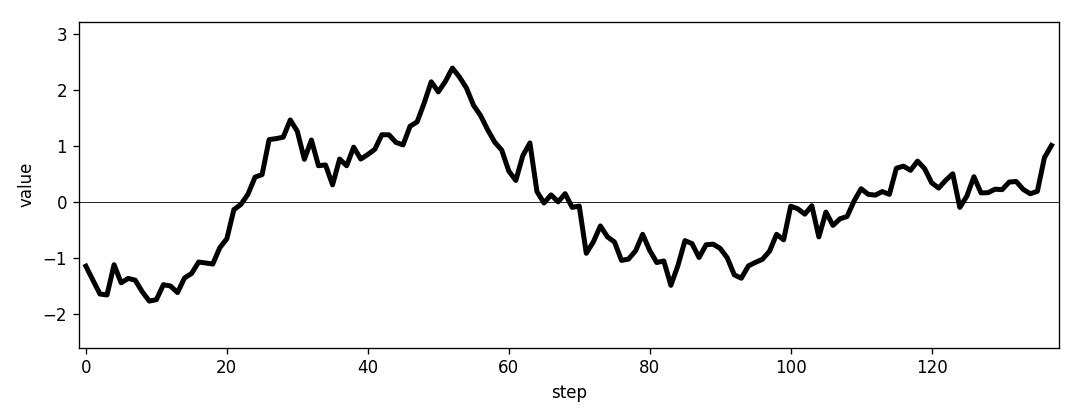

In [6]:
# Plot the standard normalized series
timelib.variable_order_plotters.plot_sequences(x)

# Define exponential average in optimization format

Define the exponential average in a modular, generalizable way.

In [7]:
def step(h_t_prev,x_t,w):
    return w*h_t_prev + (1 - w)*x_t

# exponential average function
def exponential_average(x,w):
    # set initial conditions of h to values of x
    h = [x[:,0]]
    
    # range over x and create h
    for t in range(1,np.size(x)):
        # get current point and prior hidden state
        h_t_prev = h[-1]
        x_t = x[:,t]

        # make next element and store
        h_t = step(h_t_prev,x_t,w)
        h.append(h_t)
    return np.array(h)

# create sequence with w set to particular value
w = 0.6
h = exponential_average(x,w)

Plot variable order system.

<IPython.core.display.Javascript object>


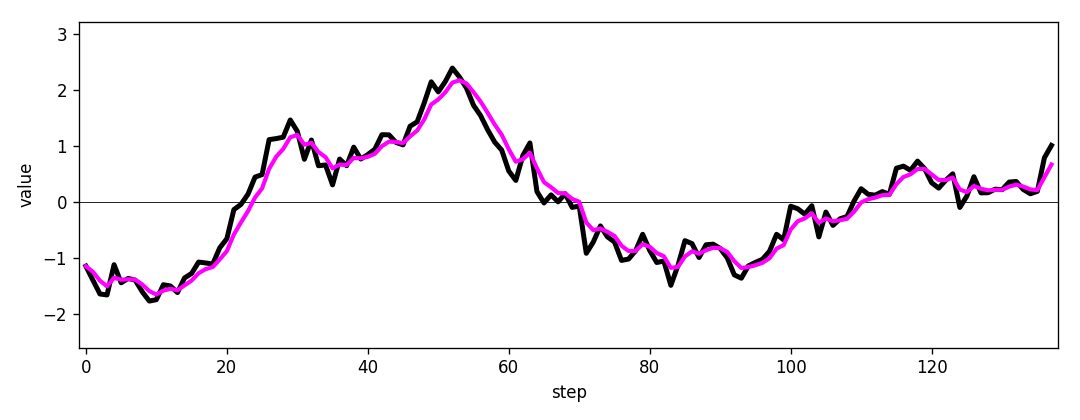

In [8]:
# Plot the standard normalized series
timelib.variable_order_plotters.plot_sequences(seq1 = x,seq2 = h)

# fit with a validation set

If we use the natural generalization of the exponential average for an update

\begin{equation}
h_{t} = w_0 + w_1h_{t-1} + w_2x_{t}
\end{equation}

for financial time series prediction, note it just won't work - since we can set all weights to zero except $w_2 = 1$ and we have perfect prediction.  So we use

\begin{equation}
h_{t} = w_0 + w_1h_{t-1} + w_2x_{t-1}
\end{equation}

In [24]:
def step(h_t_prev,x_t_prev,w):
    return w[0] + w[1]*h_t_prev + w[2]*x_t_prev
    
# exponential average function
def model(x,w):
    # set initial conditions of h to values of x
    h = [x[:,0]]
    
    # range over x and create h
    for t in range(0,np.size(x)-1):
        # get current point and prior hidden state
        h_t_prev = h[-1]
        x_t_prev = x[:,t]

        # make next element and store
        h_t = step(h_t_prev,x_t_prev,w)
        h.append(h_t)
    return np.array(h).T

# an implementation of the least squares cost function for linear regression
def least_squares(w,x,y):
    # compute cost over batch
    cost = np.sum((model(x,w) - y)**2)
    return cost/float(np.size(y))

Use custom library that takes in `model` and tunes parameters.

<IPython.core.display.Javascript object>


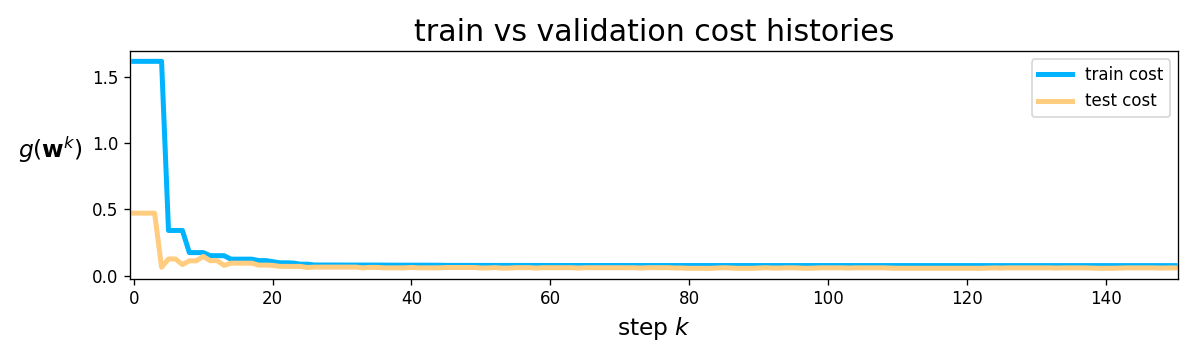

<IPython.core.display.Javascript object>


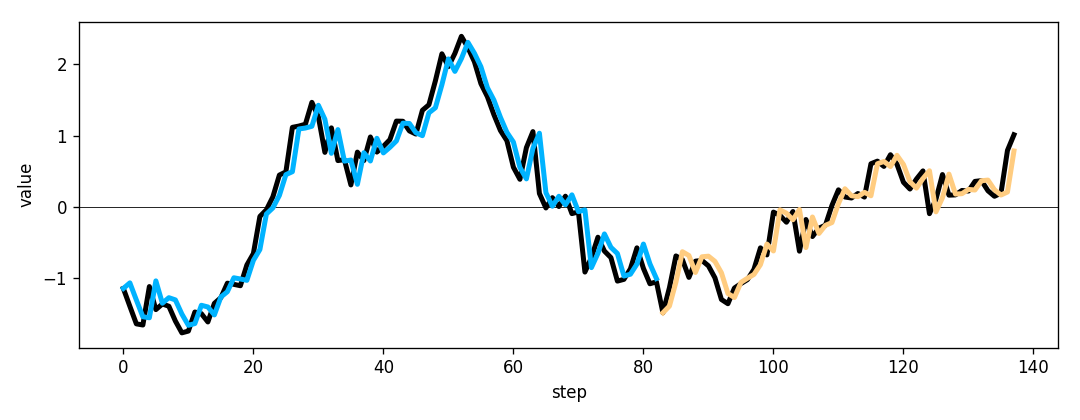

In [27]:
# This code cell will not be shown in the HTML version of this notebook
# initialize with input/output data
mylib1 = timelib.rnn_lib.super_setup.Setup(x,x)

# perform preprocessing step(s) - especially input normalization
mylib1.preprocessing_steps(normalizer = 'standard')

# split into training and validation sets
mylib1.make_train_val_split(train_portion = 0.6)

# choose cost
mylib1.choose_cost(name = 'least_squares',model = model,step = step)

# fit an optimization
w = 0.1*np.random.randn(3,1)
mylib1.fit(max_its = 50,alpha_choice = 'diminishing',optimizer = 'zero_order',w_init = w,verbose = False)

# show cost function history
mylib1.show_histories()

# Plot the standard normalized series and its training fit
timelib.variable_order_plotters.plot_train_val_sequences(mylib1)

# use as a generator

This - mechanically speaking - is just like the training / validation set mechanics above, only the history plotter contains any difference.  Inside we use the trained model as a generator.

<IPython.core.display.Javascript object>


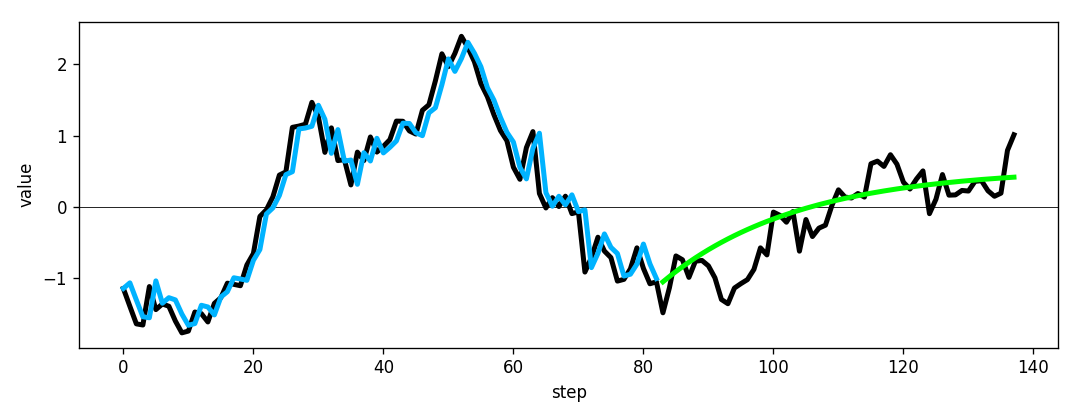

In [35]:
# Plot the standard normalized series
timelib.variable_order_plotters.plot_train_gen_sequences(mylib1)